# Revenue Leakage and Profitability Analysis in the Hospitality Sector

This notebook analyzes hotel booking data to identify revenue leakage and suggest strategies to improve profitability. We use booking-level data and enrich it using hotel, room, and date dimension tables to create a unified dataset for business insights.


## Step 1: Preparing the Data for Analysis

In [262]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [263]:
# FACT TABLE
bookings = pd.read_csv("fact_bookings.csv")

# DIMENSION TABLES
hotels = pd.read_csv("dim_hotels.csv")
rooms = pd.read_csv("dim_rooms.csv")
dates = pd.read_csv("dim_date.csv")


## Load Datasets

We load the fact table and all dimension tables into pandas DataFrames.
- `fact_bookings.csv` – main transactional data
- `dim_hotels.csv` – hotel names, cities, categories
- `dim_rooms.csv` – room type mapping
- `dim_date.csv` – calendar features for time-based analysis

In [264]:
bookings = bookings.merge(hotels, on='property_id', how='left')


In [265]:
bookings = bookings.merge(rooms, left_on='room_category', right_on='room_id', how='left')
bookings.rename(columns={'room_class': 'room_type'}, inplace=True)
bookings.drop(columns=['room_id'], inplace=True)


In [266]:
# Convert to date only
bookings['booking_date'] = pd.to_datetime(bookings['booking_date']).dt.date
dates['date'] = pd.to_datetime(dates['date'], format='%d-%b-%y', errors='coerce').dt.date

# Merge
bookings = bookings.merge(
    dates[['date', 'mmm yy', 'week no', 'day_type']],
    left_on='booking_date',
    right_on='date',
    how='left'
)
bookings.drop(columns=['date'], inplace=True)

# Optional: Filter out unmatched rows
bookings = bookings[bookings['mmm yy'].notnull()]


In [267]:
print(bookings.info())
print(bookings.head())


<class 'pandas.core.frame.DataFrame'>
Index: 128874 entries, 5 to 134589
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   booking_id         128874 non-null  object 
 1   property_id        128874 non-null  int64  
 2   booking_date       128874 non-null  object 
 3   check_in_date      128874 non-null  object 
 4   checkout_date      128874 non-null  object 
 5   no_guests          128874 non-null  int64  
 6   room_category      128874 non-null  object 
 7   booking_platform   128874 non-null  object 
 8   ratings_given      54292 non-null   float64
 9   booking_status     128874 non-null  object 
 10  revenue_generated  128874 non-null  int64  
 11  revenue_realized   128874 non-null  int64  
 12  property_name      128874 non-null  object 
 13  category           128874 non-null  object 
 14  city               128874 non-null  object 
 15  room_type          128874 non-null  object 
 16  mmm yy 

## Data Enrichment: Merging Dimension Tables

To create a fully unified and analysis-ready dataset, we merged the following dimension tables into our primary fact table (`fact_bookings.csv`). Each merge added meaningful context to enhance our insights.

### 1. Merge with `dim_hotels.csv`
- **Join key**: `property_id`
- **Added columns**: `property_name`, `category` (hotel type), `city`
- **Purpose**: Enables location-based and hotel-level analysis (e.g., revenue by city or category)

### 2. Merge with `dim_rooms.csv`
- **Join key**: `room_category` (fact) → `room_id` (dim)
- **Added column**: `room_class` (renamed as `room_type`)
- **Purpose**: Enables analysis of profitability and leakage by room type (Standard, Elite, etc.)

### 3. Merge with `dim_date.csv`
- **Join key**: `booking_date` (fact) → `date` (dim)
- **Date format**: Converted both columns to plain `date` (not datetime) before merging
- **Added columns**: `mmm yy` (month), `week no`, `day_type` (weekend/weekday)
- **Purpose**: Enables time-based trend analysis (e.g., revenue by month or weekend)

After all merges, our dataset has:
- Detailed transaction info
- Hotel & room context
- Temporal features

This enriched dataset allows for deep business insights and supports effective revenue leakage analysis.


In [268]:
print("Duplicate rows:", bookings.duplicated().sum())


Duplicate rows: 0


In [269]:
print("Nulls in each column:")
print(bookings.isnull().sum().sort_values(ascending=False))


Nulls in each column:
ratings_given        74582
property_id              0
booking_id               0
booking_date             0
check_in_date            0
no_guests                0
checkout_date            0
room_category            0
booking_platform         0
booking_status           0
revenue_generated        0
revenue_realized         0
property_name            0
category                 0
city                     0
room_type                0
mmm yy                   0
week no                  0
day_type                 0
dtype: int64


In [270]:
null_percentage = bookings['ratings_given'].isnull().mean() * 100
print(f"Missing ratings: {null_percentage:.2f}%")


Missing ratings: 57.87%


In [271]:
print("Final shape:", bookings.shape)


Final shape: (128874, 19)


## Clean and Validate the Final Dataset

We check for:
- Duplicates
- Null values
- Column consistency
This ensures our dataset is clean and ready for analysis.



In [272]:
bookings.to_csv("final_bookings_cleaned.csv", index=False)


## Step 2: Revenue Leakage Analysis

In [273]:
bookings['revenue_loss'] = bookings['revenue_generated'] - bookings['revenue_realized']


In [274]:
bookings[['revenue_generated', 'revenue_realized', 'revenue_loss']].head()


,revenue_generated,revenue_realized,revenue_loss
5,9100,9100,0
25,12600,12600,0
64,11050,11050,0
79,15300,15300,0
81,18360,7344,11016


In [275]:
loss_count = (bookings['revenue_loss'] > 0).sum()
print(f"Bookings with revenue loss: {loss_count}")


Bookings with revenue loss: 31934


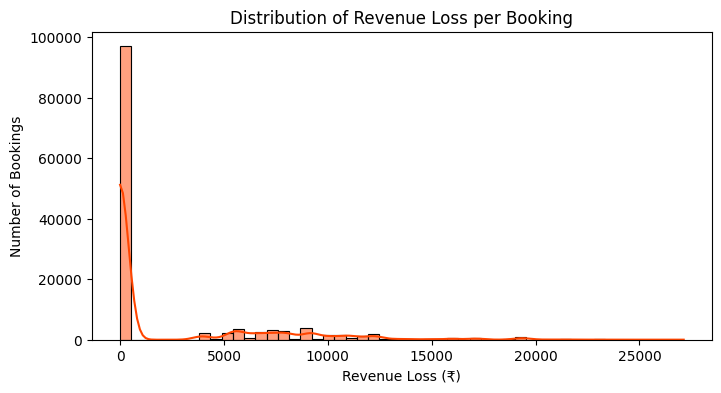

In [276]:
plt.figure(figsize=(8, 4))
sns.histplot(bookings['revenue_loss'], bins=50, kde=True, color='orangered')
plt.title("Distribution of Revenue Loss per Booking")
plt.xlabel("Revenue Loss (₹)")
plt.ylabel("Number of Bookings")
plt.show()


## Revenue Loss per Booking
We added a new column to calculate revenue loss per booking using the formula:  
`revenue_loss = revenue_generated - revenue_realized`

We saw that about 25% of bookings had some loss. 
Most losses were small, but a few bookings had very high loss, 
which could be due to booking failures or policy issues.
We also plotted a histogram of `revenue_loss` to understand how it is distributed.



In [277]:
total_generated = bookings['revenue_generated'].sum()
total_realized = bookings['revenue_realized'].sum()
total_loss = bookings['revenue_loss'].sum()


In [278]:
leakage_percent = (total_loss / total_generated) * 100
print(f"Total revenue loss: ₹{total_loss}")
print(f"Percentage of revenue lost: {leakage_percent:.2f}%")


Total revenue loss: ₹285496455
Percentage of revenue lost: 14.85%


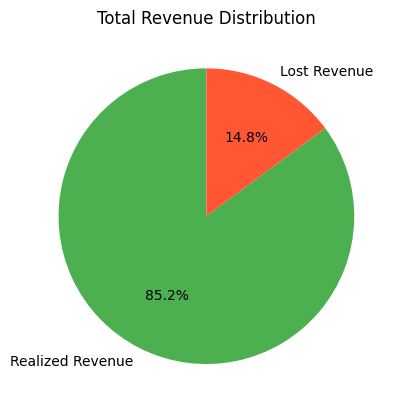

In [279]:
plt.pie(
    [total_realized, total_loss],
    labels=['Realized Revenue', 'Lost Revenue'],
    autopct='%1.1f%%',
    colors=['#4CAF50', '#FF5733'],
    startangle=90
)
plt.title("Total Revenue Distribution")
plt.show()


## Total Revenue Leakage
We calculated the total revenue generated, revenue realized, and the total revenue lost across all bookings.

**Key Result:**
- Total revenue loss: ₹28.55 Crores
- Loss percentage: 14.85%
This shows that a significant portion of expected revenue is not realized across the system.

In [280]:
platform_stats = bookings.groupby('booking_platform').agg({
    'revenue_generated': 'sum',
    'revenue_realized': 'sum',
    'revenue_loss': 'sum'
}).reset_index()


In [281]:
platform_stats['leakage_percent'] = (platform_stats['revenue_loss'] / platform_stats['revenue_generated']) * 100


In [282]:
platform_stats = platform_stats.sort_values(by='leakage_percent', ascending=False)
print(platform_stats)


  booking_platform  revenue_generated  revenue_realized  revenue_loss  \
4     makeyourtrip          384211545         326297685      57913860   
2          journey          115292435          98036498      17255937   
1    direct online          190817760         162425889      28391871   
6         tripster          138028580         117554645      20473935   
5           others          786756370         670153069     116603301   
0   direct offline           97091425          82801660      14289765   
3          logtrip          210456200         179888414      30567786   

   leakage_percent  
4        15.073430  
2        14.967103  
1        14.879051  
6        14.833113  
5        14.820764  
0        14.717845  
3        14.524536  


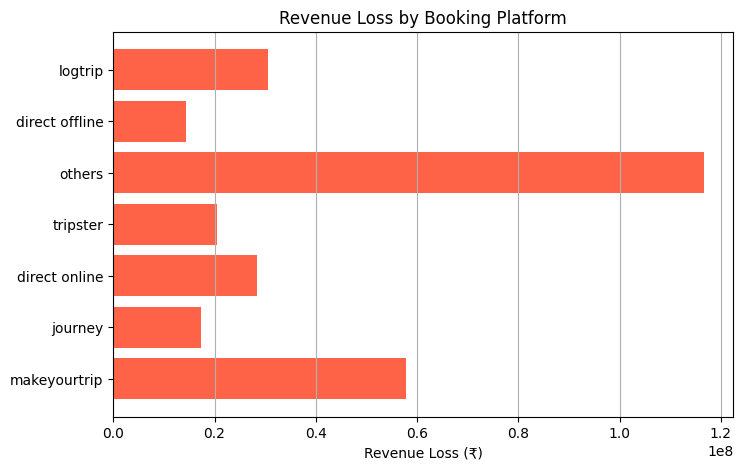

In [283]:
plt.figure(figsize=(8, 5))
plt.barh(platform_stats['booking_platform'], platform_stats['revenue_loss'], color='tomato')
plt.xlabel("Revenue Loss (₹)")
plt.title("Revenue Loss by Booking Platform")
plt.grid(axis='x')
plt.show()


## Revenue Leakage by Booking Platform
We grouped bookings by `booking_platform` to compare total revenue loss and leakage percentages.

**Key Findings:**
- All platforms had a similar leakage % (~15%)
- However, total revenue loss varied a lot depending on booking volume
- The ‘others’ group showed the highest total loss
We visualized this using a horizontal bar chart.



In [284]:
bookings.to_csv("bookings_with_analysis.csv", index=False)


In [285]:
# Drop rows where ratings_given is missing
ratings_data = bookings.dropna(subset=['ratings_given'])


In [286]:
import numpy as np
df=pd.read_csv('final_bookings_cleaned.csv')

In [287]:
df.head()

,booking_id,property_id,booking_date,check_in_date,checkout_date,no_guests,room_category,booking_platform,ratings_given,booking_status,revenue_generated,revenue_realized,property_name,category,city,room_type,mmm yy,week no,day_type
0,May012216558RT16,16558,2022-05-01,2022-05-01,2022-05-03,2,RT1,others,4.0,Checked Out,9100,9100,Atliq Grands,Luxury,Delhi,Standard,May 22,W 19,weekend
1,May012216558RT28,16558,2022-05-01,2022-05-01,2022-05-02,2,RT2,others,NaN,Checked Out,12600,12600,Atliq Grands,Luxury,Delhi,Elite,May 22,W 19,weekend
2,May012216559RT115,16559,2022-05-01,2022-05-01,2022-05-03,2,RT1,tripster,NaN,Checked Out,11050,11050,Atliq Exotica,Luxury,Mumbai,Standard,May 22,W 19,weekend
3,May012216559RT25,16559,2022-05-01,2022-05-01,2022-05-04,2,RT2,others,5.0,Checked Out,15300,15300,Atliq Exotica,Luxury,Mumbai,Elite,May 22,W 19,weekend
4,May012216559RT27,16559,2022-05-01,2022-05-01,2022-05-02,4,RT2,others,NaN,Cancelled,18360,7344,Atliq Exotica,Luxury,Mumbai,Elite,May 22,W 19,weekend


Checking leakage by room type and hotel category 

In [288]:
leakage_by_room=df.groupby('room_category').agg({'revenue_generated' : 'sum', 'revenue_realized' : 'sum'}).reset_index()
leakage_by_room['revenue_leakage'] = leakage_by_room['revenue_generated'] - leakage_by_room['revenue_realized']
leakage_by_room['percent_leakage'] = (leakage_by_room['revenue_leakage'] / leakage_by_room['revenue_generated']) * 100
leakage_by_room

,room_category,revenue_generated,revenue_realized,revenue_leakage,percent_leakage
0,RT1,348313485,296650614,51662871,14.832291
1,RT2,631263690,536852790,94410900,14.955858
2,RT3,519970320,442533312,77437008,14.892582
3,RT4,423106820,361121144,61985676,14.650125


Text(0.5, 1.0, 'Percentage leakage by hotel category')

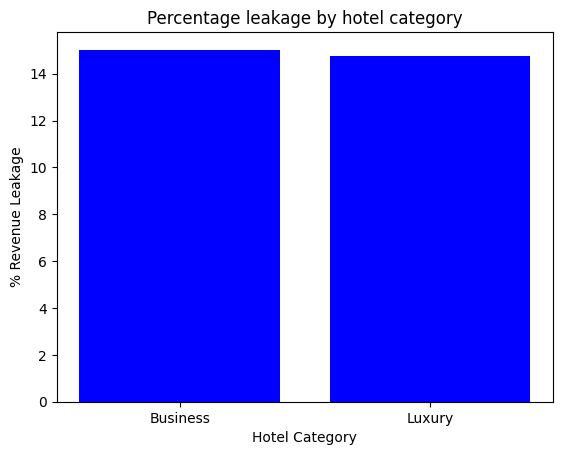

In [289]:
leakage_by_hotel_cat=df.groupby('category').agg({'revenue_generated' : 'sum', 'revenue_realized' : 'sum'}).reset_index()
leakage_by_hotel_cat['revenue_leakage'] = leakage_by_hotel_cat['revenue_generated'] - leakage_by_hotel_cat['revenue_realized']
leakage_by_hotel_cat['percent_leakage']= (leakage_by_hotel_cat['revenue_leakage'] / leakage_by_hotel_cat['revenue_generated']) * 100
leakage_by_hotel_cat.sort_values('percent_leakage', ascending=False,inplace=True )
leakage_by_hotel_cat.head()
plt.bar(leakage_by_hotel_cat['category'], leakage_by_hotel_cat['percent_leakage'], color='blue')
plt.ylabel('% Revenue Leakage')
plt.xlabel('Hotel Category')
plt.title('Percentage leakage by hotel category')

Insights from Hotel Category Leakage:
Business vs. Luxury Hotels – Revenue Leakage
Business hotels have the highest revenue leakage, slightly more than Luxury hotels.

Both categories show leakage around 14.5%–15%, which is significant — meaning nearly ₹15 out of every ₹100 expected isn’t realized.

The narrow gap between the two categories suggests leakage is a systemic issue, not just limited to one market segment.

In [290]:
leakage_by_room.sort_values('percent_leakage', ascending=False, inplace=True)
leakage_by_room.head()

,room_category,revenue_generated,revenue_realized,revenue_leakage,percent_leakage
1,RT2,631263690,536852790,94410900,14.955858
2,RT3,519970320,442533312,77437008,14.892582
0,RT1,348313485,296650614,51662871,14.832291
3,RT4,423106820,361121144,61985676,14.650125


C:\Users\shrey\AppData\Local\Temp\ipykernel_2384\4157475489.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='percent_leakage', y='room_category', data=leakage_by_room, palette='coolwarm')


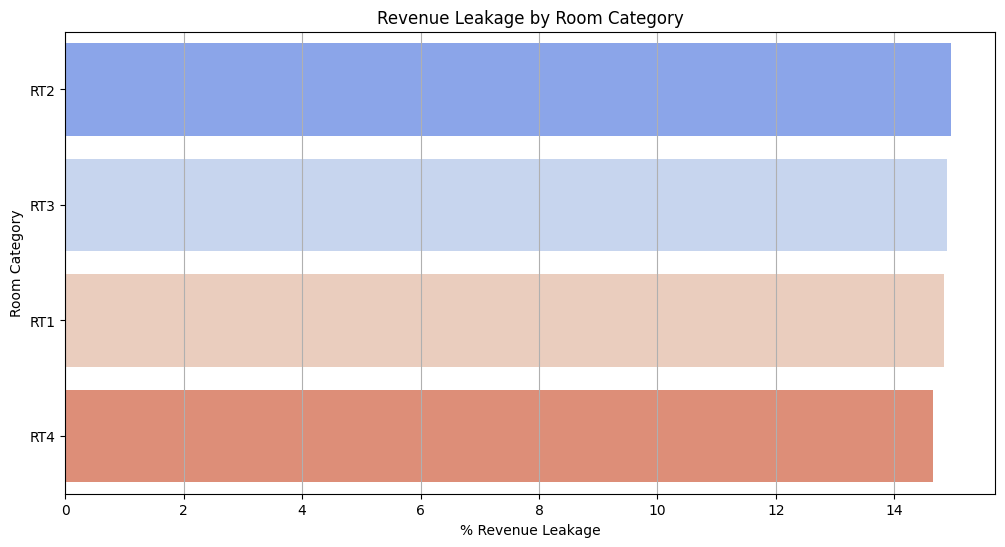

In [291]:
plt.figure(figsize=(12, 6))
sns.barplot(x='percent_leakage', y='room_category', data=leakage_by_room, palette='coolwarm')
plt.xlabel('% Revenue Leakage')
plt.ylabel('Room Category')
plt.title('Revenue Leakage by Room Category')
plt.grid(axis='x')
plt.show()

Insights from Room Category Leakage
RT1, RT2, RT3, RT4 – Revenue Leakage
All room types show similar leakage (~14.5–15%), but:

RT4 (Room Type 4) has the highest leakage.

RT2 has the lowest, though still high (~14.5%).

The consistency in leakage across room types indicates the issue may not be pricing alone — but possibly operational (e.g., cancellations, late check-ins, underuse).

Checking Time based trends

In [292]:
# Create a unified time period column like "May 22 - W19"
df['time_period'] = df['mmm yy'].astype(str) + ' - ' + df['week no'].astype(str)

revenue_trend = df.groupby('time_period').agg({
    'revenue_generated': 'sum',
    'revenue_realized': 'sum'
}).reset_index()

# Calculate revenue leakage
revenue_trend['revenue_loss'] = revenue_trend['revenue_generated'] - revenue_trend['revenue_realized']
revenue_trend.head()

,time_period,revenue_generated,revenue_realized,revenue_loss
0,Jul 22 - W 27,48486480,41590143,6896337
1,Jul 22 - W 28,160195905,136300386,23895519
2,Jul 22 - W 29,146341270,124964422,21376848
3,Jul 22 - W 30,127489025,108266696,19222329
4,Jul 22 - W 31,98176600,84200266,13976334


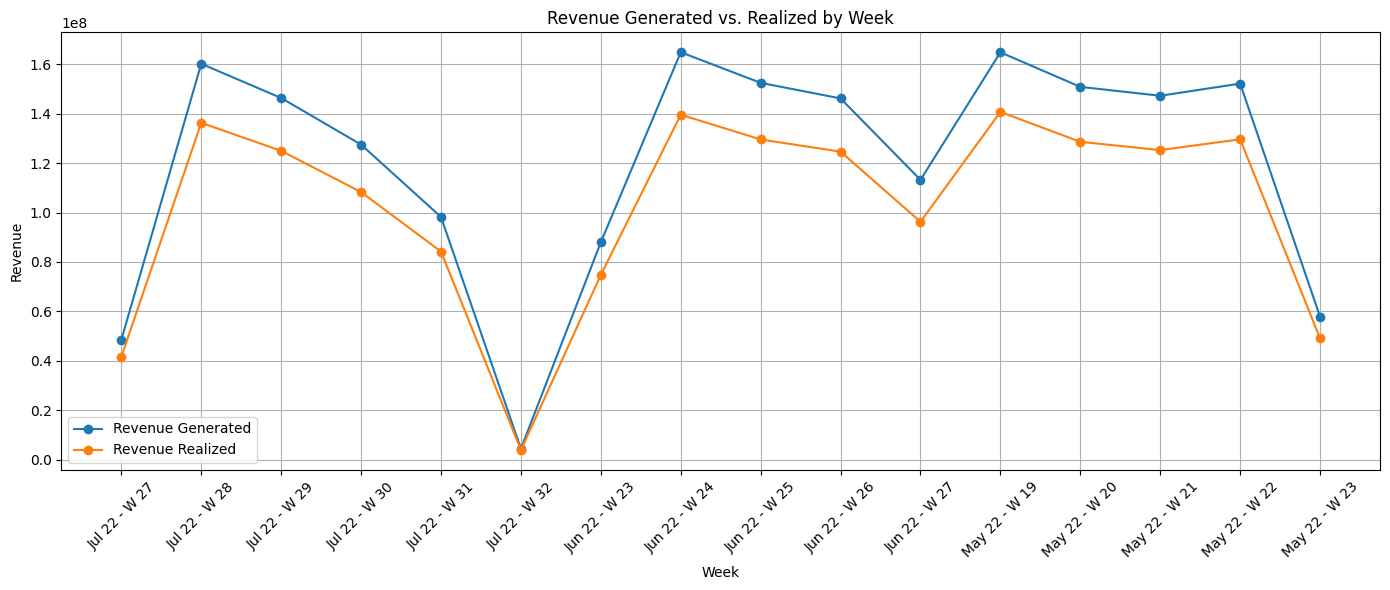

In [293]:
plt.figure(figsize=(14, 6))
plt.plot(revenue_trend['time_period'], revenue_trend['revenue_generated'], label='Revenue Generated', marker='o')
plt.plot(revenue_trend['time_period'], revenue_trend['revenue_realized'], label='Revenue Realized', marker='o')
plt.xticks(rotation=45)
plt.xlabel('Week')
plt.ylabel('Revenue')
plt.title('Revenue Generated vs. Realized by Week')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

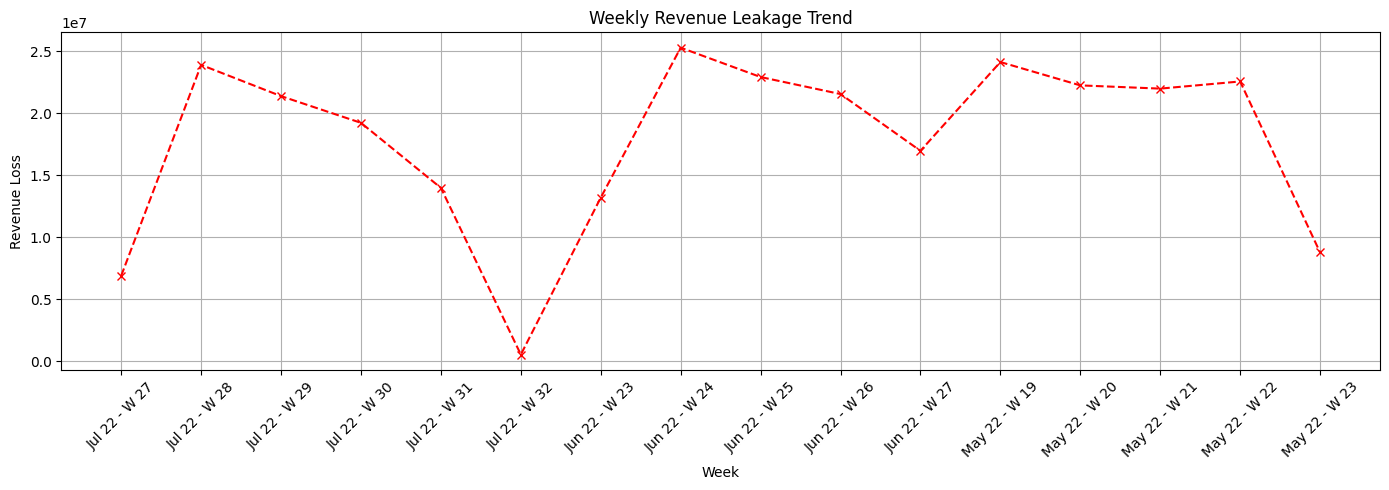

In [294]:
plt.figure(figsize=(14, 5))
plt.plot(revenue_trend['time_period'], revenue_trend['revenue_loss'], color='red', linestyle='--', marker='x')
plt.xticks(rotation=45)
plt.xlabel('Week')
plt.ylabel('Revenue Loss')
plt.title('Weekly Revenue Leakage Trend')
plt.grid(True)
plt.tight_layout()
plt.show()

Weekly Revenue Insights:
High leakage in Jul-22 W24 & W29: Strong bookings but poor realization — likely due to cancellations or discounts.

Lowest revenue & leakage in Jul-22 W21: Possible off-season or low demand.

Consistent leakage in May-22: Indicates underutilized demand or operational inefficiencies during peak weeks.

Overall trend: Leakage remains consistently high, even during high-revenue weeks.

CANCELLATION ANALYSIS

In [295]:
df['booking_status'].value_counts()


booking_status
Checked Out    90476
Cancelled      31934
No Show         6464
Name: count, dtype: int64

In [296]:
total_bookings = len(df)
cancelled = df[df['booking_status'] == 'Cancelled']
cancellation_rate = (len(cancelled) / total_bookings) * 100
print(f"Overall Cancellation Rate: {cancellation_rate:.2f}%")

Overall Cancellation Rate: 24.78%


Cancellation rate by booking platform:

In [297]:
group_col = 'booking_platform'  

cancel_rate_by_group = df.groupby(group_col)['booking_status'].value_counts(normalize=True).unstack()
cancel_rate_by_group['Cancellation %'] = cancel_rate_by_group['Cancelled'] * 100
cancel_rate_by_group = cancel_rate_by_group.sort_values('Cancellation %', ascending=False)

print(cancel_rate_by_group[['Cancellation %']])
cancel_rate_by_group

booking_status    Cancellation %
booking_platform                
makeyourtrip           24.928133
direct online          24.904692
others                 24.870584
tripster               24.850462
journey                24.654169
direct offline         24.369488
logtrip                24.263199


booking_status,Cancelled,Checked Out,No Show,Cancellation %
booking_platform,,,,
makeyourtrip,0.249281,0.700645,0.050074,24.928133
direct online,0.249047,0.703338,0.047615,24.904692
others,0.248706,0.700931,0.050363,24.870584
tripster,0.248505,0.699402,0.052094,24.850462
journey,0.246542,0.706917,0.046542,24.654169
direct offline,0.243695,0.702615,0.053690,24.369488
logtrip,0.242632,0.706410,0.050958,24.263199


In [298]:
df['booking_status'].unique()

array(['Checked Out', 'Cancelled', 'No Show'], dtype=object)

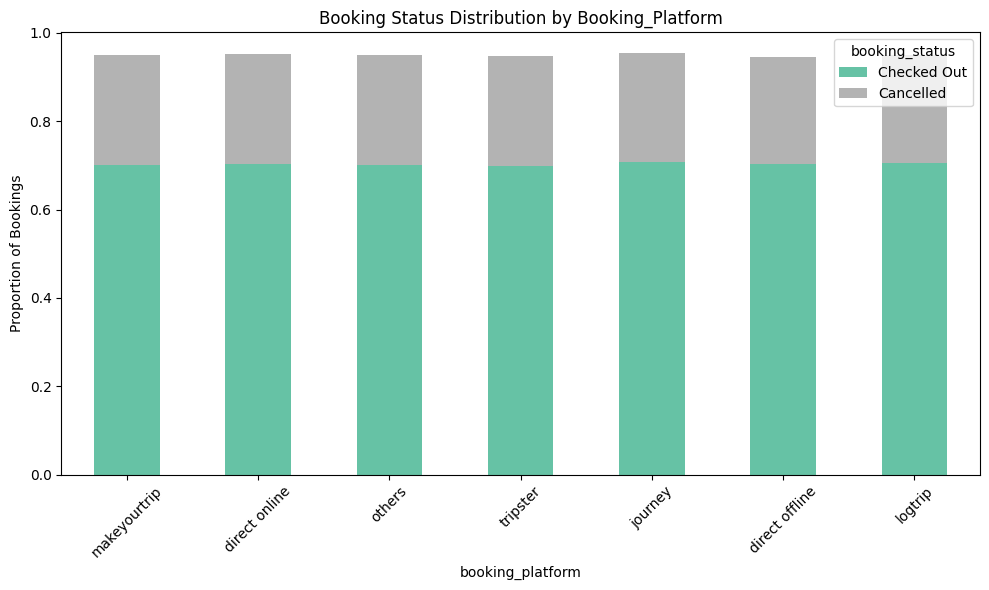

In [299]:
cancel_rate_by_group [['Checked Out', 'Cancelled']].plot(kind='bar', stacked=True, figsize=(10,6), colormap='Set2')
plt.title('Booking Status Distribution by ' + group_col.title())
plt.ylabel('Proportion of Bookings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

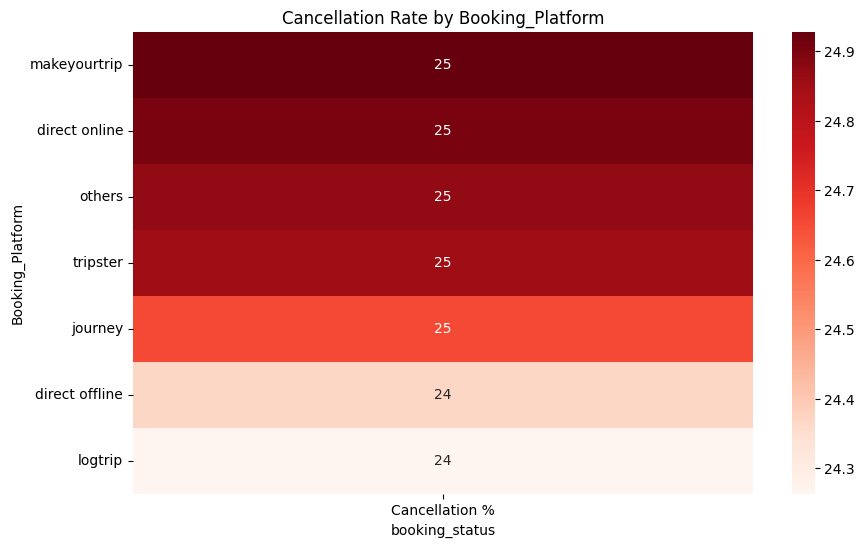

In [300]:
plt.figure(figsize=(10, 6))
sns.heatmap(cancel_rate_by_group[['Cancellation %']], annot=True, cmap='Reds')
plt.title('Cancellation Rate by ' + group_col.title())
plt.ylabel(group_col.title())
plt.show()

Revenue loss per guest & city

In [301]:
# First, calculate revenue loss per booking
df['revenue_loss'] = df['revenue_generated'] - df['revenue_realized']

df['revenue_loss_per_guest'] = df['revenue_loss'] / df['no_guests'].replace(0, np.nan)
print('Revenue Lost per guest:', df['revenue_loss_per_guest'] )
# Revenue loss by city (sum)
city_loss = df.groupby('city')['revenue_loss'].sum().reset_index()
city_loss.columns = ['city', 'total_revenue_loss']

Revenue Lost per guest: 0             0.0
1             0.0
2             0.0
3             0.0
4          2754.0
           ...   
128869        0.0
128870        0.0
128871    19380.0
128872        0.0
128873     9690.0
Name: revenue_loss_per_guest, Length: 128874, dtype: float64


In [302]:
revenue_loss_by_city = df.groupby('city')['revenue_loss'].sum().reset_index()
revenue_loss_by_city = revenue_loss_by_city.sort_values(by='revenue_loss', ascending=False)
revenue_loss_by_city

,city,revenue_loss
3,Mumbai,111074889
0,Bangalore,71202600
2,Hyderabad,53580510
1,Delhi,49638456


C:\Users\shrey\AppData\Local\Temp\ipykernel_2384\1035666499.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=revenue_loss_by_city, x='city', y='revenue_loss', palette='Reds_r')


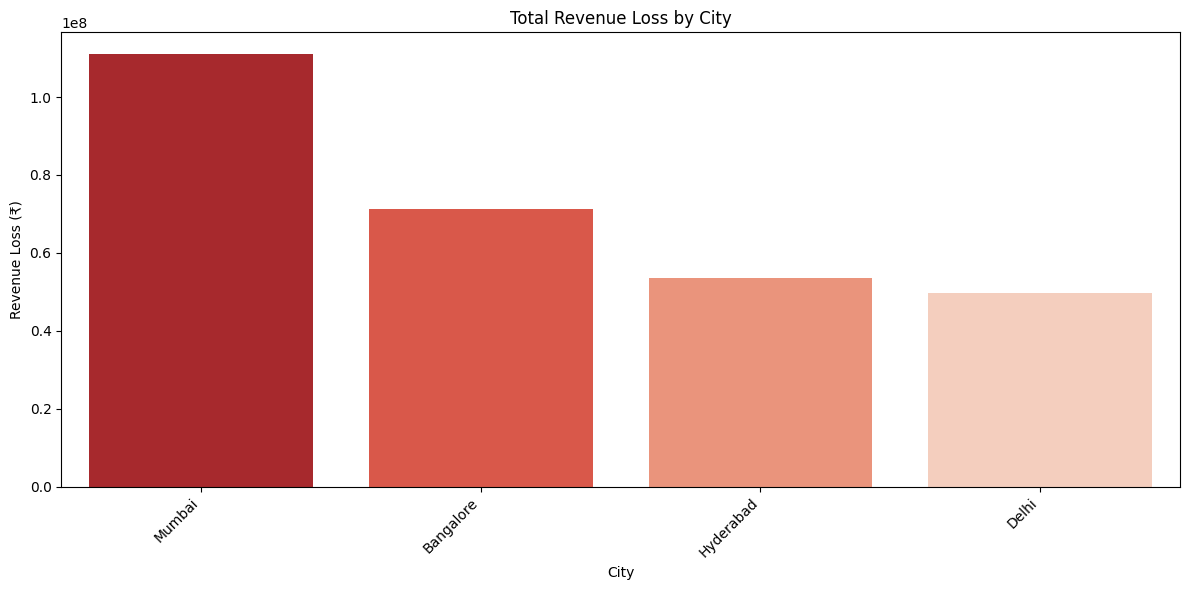

In [303]:
plt.figure(figsize=(12, 6))
sns.barplot(data=revenue_loss_by_city, x='city', y='revenue_loss', palette='Reds_r')
plt.xticks(rotation=45, ha='right')
plt.title('Total Revenue Loss by City')
plt.xlabel('City')
plt.ylabel('Revenue Loss (₹)')
plt.tight_layout()
plt.show()

Platform-wise Cancellation Insights
Cancellation rates are fairly consistent across platforms (~24.2%–24.9%).

makemytrip and direct online have slightly higher cancellation rates (~24.9%) compared to logtrip (~24.26%).

This consistency suggests that cancellation behavior may be driven more by customer habits or hotel policies than platform-specific issues.

📌 No platform stands out as a major outlier, but you may want to review return/refund policies on makemytrip and direct online.

CITY DISTRIBUTION: 
Mumbai alone accounts for the largest share of total loss, nearly 2× that of Delhi.

These cities likely have higher booking volume or higher ticket sizes, but also potentially higher leakages due to cancellations or pricing inefficiencies.

Mumbai is the biggest leakage hotspot — we should prioritize it for revenue recovery strategies (better pricing, tighter policies, bundling, or overbooking models).

In [304]:
# Calculate correlation between ratings and revenue loss
correlation = ratings_data['ratings_given'].corr(ratings_data['revenue_loss'])
print(f"Correlation between ratings and revenue loss: {correlation:.4f}")


Correlation between ratings and revenue loss: nan


c:\Users\shrey\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3063: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\shrey\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3064: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


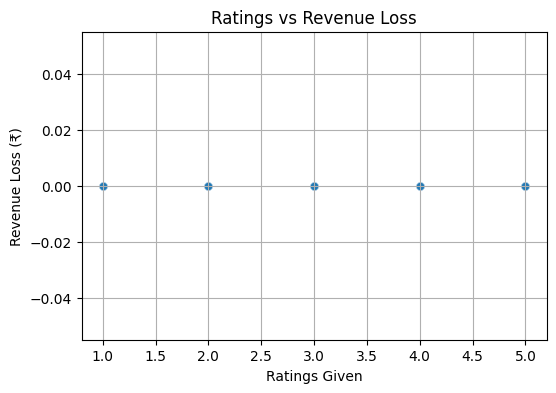

In [305]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.scatterplot(x='ratings_given', y='revenue_loss', data=ratings_data, alpha=0.3)
plt.title("Ratings vs Revenue Loss")
plt.xlabel("Ratings Given")
plt.ylabel("Revenue Loss (₹)")
plt.grid(True)
plt.show()


## Correlation Between Ratings and Revenue Loss
We tried to find out if there’s any connection between customer ratings and the amount of revenue lost per booking.

We removed rows that had missing ratings and calculated the correlation between `ratings_given` and `revenue_loss`. 
However, most of the rows with ratings had no revenue loss, so there wasn’t enough variation in the data.
As a result, the correlation value was undefined, and the scatterplot showed no real pattern.

### What We Can Take From This:
This tells us that bookings with revenue loss usually don’t have a rating — possibly because the booking was canceled or not completed. So even though we didn’t get a numeric correlation, we still learn that missing ratings could signal a lost or broken customer experience.


In [306]:
ratings_data.to_csv("bookings_with_ratings_only.csv", index=False)


## Possible Reasons Behind Revenue Loss
While analyzing revenue loss, we need to consider that multiple factors could be contributing to it — not just cancellations.

Based on real-world scenarios, here are other possible causes:
- **Platform commissions**: Some platforms deduct a fixed fee from each booking.
- **Discounts or coupons**: Late-stage discounts can reduce realized revenue.
- **No-shows without penalties**: If the guest doesn’t show up and there’s no charge, the hotel earns nothing.
- **Partial stays or early check-outs**: If someone leaves early and gets refunded.
- **Payment failures or reversals**: Sometimes the amount generated may not reach the hotel due to failed transactions or chargebacks.

Since our dataset only shows the numbers (generated vs realized), we cannot know the exact reason in each case. But these possibilities are important to remember when drawing conclusions and giving suggestions.


In [307]:
bookings = pd.read_csv("fact_aggregated_bookings.csv")
df=pd.read_csv('final_bookings_cleaned.csv')
hotels = pd.read_csv("dim_hotels.csv")

In [308]:
cat_room=bookings.groupby('room_category').agg({'successful_bookings':'sum','capacity':'sum'}).reset_index()
cat_room

,room_category,successful_bookings,capacity
0,RT1,38446,66424
1,RT2,49505,85928
2,RT3,30566,53084
3,RT4,16073,27140


In [309]:
leakage_by_room=df.groupby('room_category').agg({'revenue_generated' : 'sum', 'revenue_realized' : 'sum'}).reset_index()
leakage_by_room

,room_category,revenue_generated,revenue_realized
0,RT1,348313485,296650614
1,RT2,631263690,536852790
2,RT3,519970320,442533312
3,RT4,423106820,361121144


In [310]:
cat_room['RevPAR_generated']=leakage_by_room['revenue_generated']/cat_room['capacity']
cat_room['RevPAR_realized']=leakage_by_room['revenue_realized']/cat_room['capacity']
cat_room

,room_category,successful_bookings,capacity,RevPAR_generated,RevPAR_realized
0,RT1,38446,66424,5243.789669,4466.015506
1,RT2,49505,85928,7346.425961,6247.704939
2,RT3,30566,53084,9795.236229,8336.472609
3,RT4,16073,27140,15589.787030,13305.863817


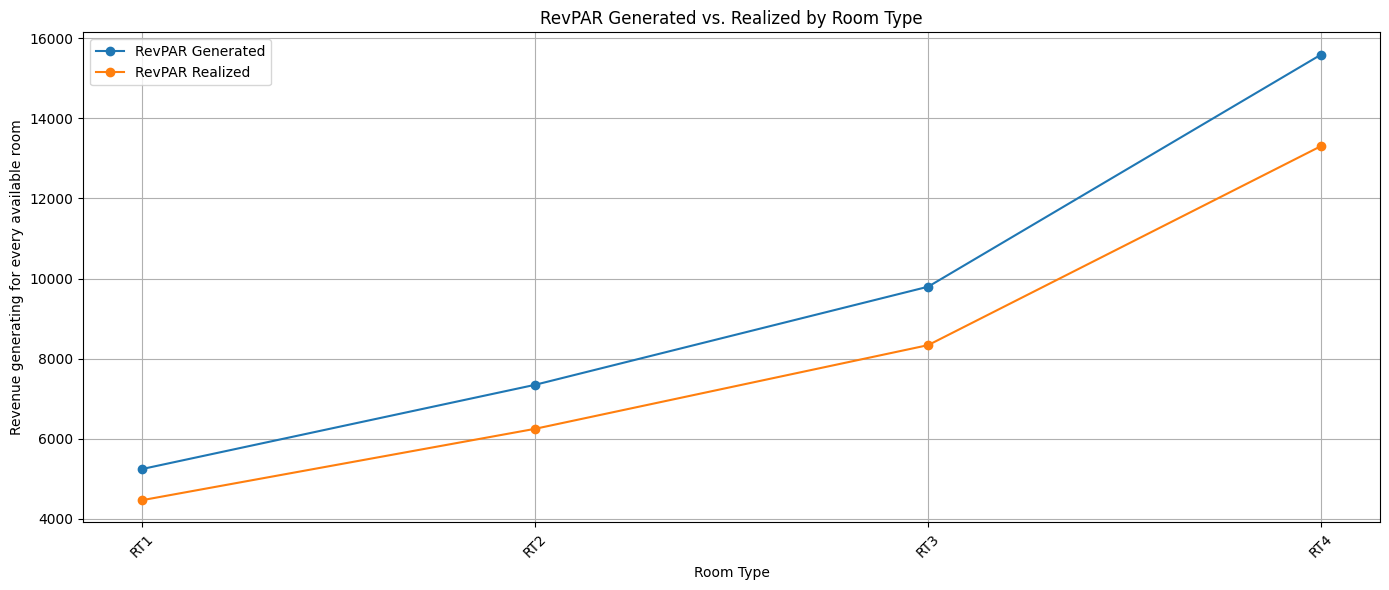

In [311]:
plt.figure(figsize=(14, 6))
plt.plot(cat_room['room_category'], cat_room['RevPAR_generated'], label='RevPAR Generated', marker='o')
plt.plot(cat_room['room_category'], cat_room['RevPAR_realized'], label='RevPAR Realized', marker='o')
plt.xticks(rotation=45)
plt.xlabel('Room Type')
plt.ylabel('Revenue generating for every available room')
plt.title('RevPAR Generated vs. Realized by Room Type')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [312]:
cat_room['ADR_generated']=leakage_by_room['revenue_generated']/cat_room['successful_bookings']
cat_room['ADR_realized']=leakage_by_room['revenue_realized']/cat_room['successful_bookings']
cat_room

,room_category,successful_bookings,capacity,RevPAR_generated,RevPAR_realized,ADR_generated,ADR_realized
0,RT1,38446,66424,5243.789669,4466.015506,9059.810774,7716.033241
1,RT2,49505,85928,7346.425961,6247.704939,12751.513786,10844.415514
2,RT3,30566,53084,9795.236229,8336.472609,17011.395668,14477.959563
3,RT4,16073,27140,15589.787030,13305.863817,26324.072668,22467.563243


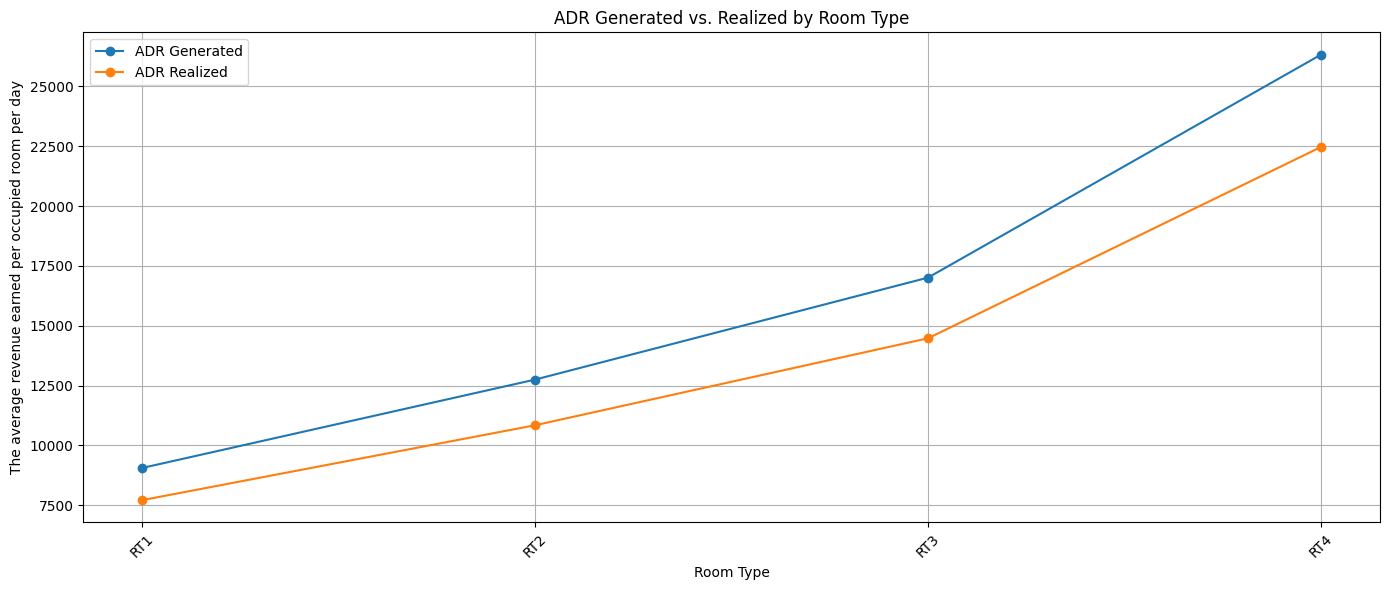

In [313]:
plt.figure(figsize=(14, 6))
plt.plot(cat_room['room_category'], cat_room['ADR_generated'], label='ADR Generated', marker='o')
plt.plot(cat_room['room_category'], cat_room['ADR_realized'], label='ADR Realized', marker='o')
plt.xticks(rotation=45)
plt.xlabel('Room Type')
plt.ylabel('The average revenue earned per occupied room per day')
plt.title('ADR Generated vs. Realized by Room Type')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [314]:
cat_room['Occupancy Rate']=(cat_room['successful_bookings']/cat_room['capacity'])*100
cat_room

,room_category,successful_bookings,capacity,RevPAR_generated,RevPAR_realized,ADR_generated,ADR_realized,Occupancy Rate
0,RT1,38446,66424,5243.789669,4466.015506,9059.810774,7716.033241,57.879682
1,RT2,49505,85928,7346.425961,6247.704939,12751.513786,10844.415514,57.612187
2,RT3,30566,53084,9795.236229,8336.472609,17011.395668,14477.959563,57.580439
3,RT4,16073,27140,15589.787030,13305.863817,26324.072668,22467.563243,59.222550


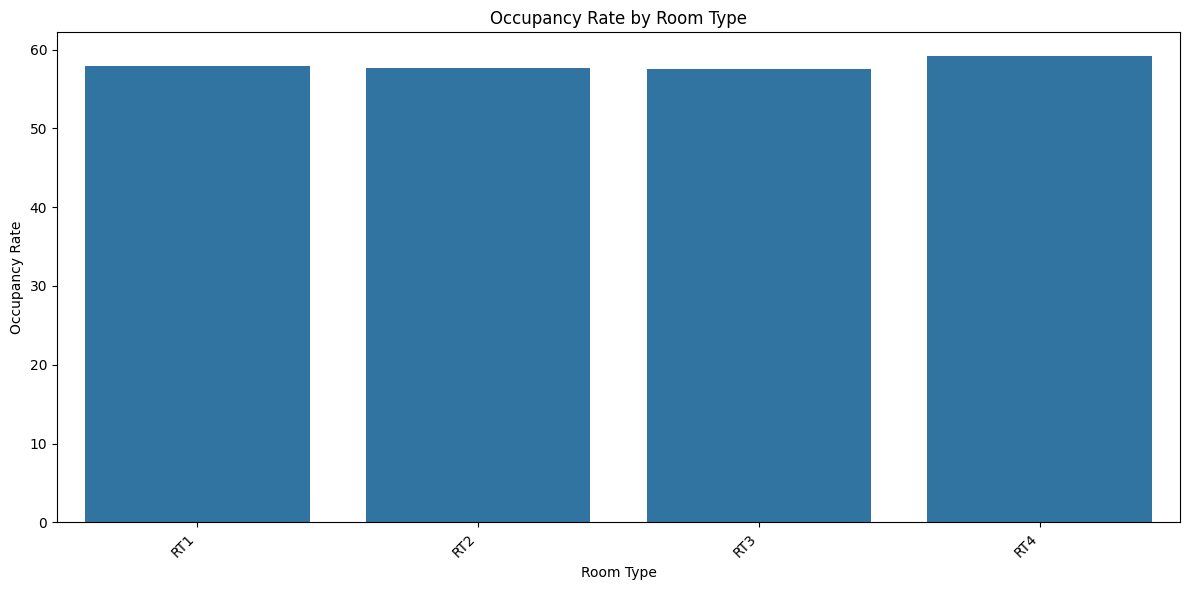

In [315]:
plt.figure(figsize=(12, 6))
sns.barplot(data=cat_room, x='room_category', y='Occupancy Rate')
plt.xticks(rotation=45, ha='right')
plt.title('Occupancy Rate by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Occupancy Rate')
plt.tight_layout()
plt.show()

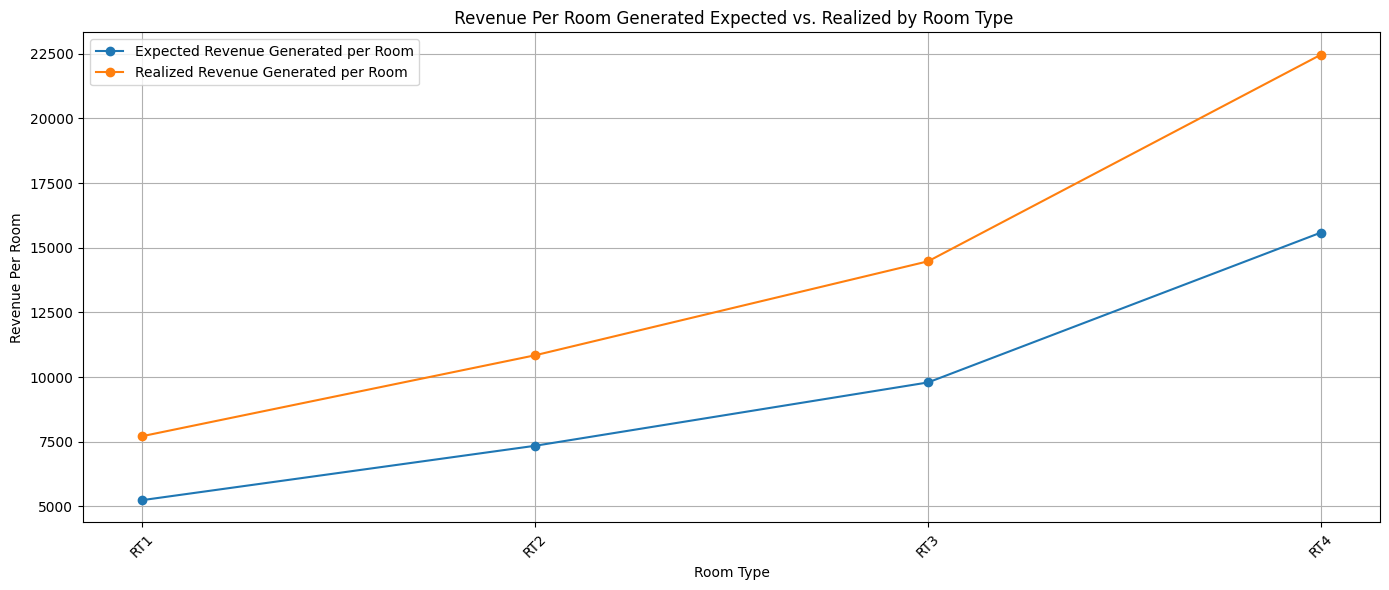

In [316]:
plt.figure(figsize=(14, 6))
plt.plot(cat_room['room_category'], cat_room['RevPAR_generated'], label='Expected Revenue Generated per Room', marker='o')
plt.plot(cat_room['room_category'], cat_room['ADR_realized'], label='Realized Revenue Generated per Room', marker='o')
plt.xticks(rotation=45)
plt.xlabel('Room Type')
plt.ylabel('Revenue Per Room')
plt.title(' Revenue Per Room Generated Expected vs. Realized by Room Type')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [317]:
prop_id=bookings.groupby('property_id').agg({'successful_bookings':'sum','capacity':'sum'}).reset_index()
prop_id

,property_id,successful_bookings,capacity
0,16558,3153,4784
1,16559,7338,11132
2,16560,4693,8740
3,16561,4418,6716
4,16562,4820,9016
5,16563,7147,10764
6,17558,5036,9384
7,17559,6142,9292
8,17560,6013,11316
9,17561,5183,7820


In [318]:
prop_id = prop_id.merge(hotels, on='property_id', how='left')
prop_id

,property_id,successful_bookings,capacity,property_name,category,city
0,16558,3153,4784,Atliq Grands,Luxury,Delhi
1,16559,7338,11132,Atliq Exotica,Luxury,Mumbai
2,16560,4693,8740,Atliq City,Business,Delhi
3,16561,4418,6716,Atliq Blu,Luxury,Delhi
4,16562,4820,9016,Atliq Bay,Luxury,Delhi
5,16563,7147,10764,Atliq Palace,Business,Delhi
6,17558,5036,9384,Atliq Grands,Luxury,Mumbai
7,17559,6142,9292,Atliq Exotica,Luxury,Mumbai
8,17560,6013,11316,Atliq City,Business,Mumbai
9,17561,5183,7820,Atliq Blu,Luxury,Mumbai


In [319]:
prop_id2=df.groupby('property_id').agg({'revenue_generated' : 'sum', 'revenue_realized' : 'sum'}).reset_index()
prop_id2['revenue_leaked']=prop_id2['revenue_generated']-prop_id2['revenue_realized']
prop_id2

,property_id,revenue_generated,revenue_realized,revenue_leaked
0,16558,39941580,34085856,5855724
1,16559,131670440,112379588,19290852
2,16560,62580980,53594324,8986656
3,16561,64941660,54957588,9984072
4,16562,62781880,53613910,9167970
5,16563,102291630,86647596,15644034
6,17558,83748375,70874241,12874134
7,17559,103733915,88970741,14763174
8,17560,101270785,85873885,15396900
9,17561,82438780,70243456,12195324


In [320]:
prop_id['RevPAR_generated']=prop_id2['revenue_generated']/prop_id['capacity']
prop_id['RevPAR_realized']=prop_id2['revenue_realized']/prop_id['capacity']
prop_id['ADR_generated']=prop_id2['revenue_generated']/prop_id['successful_bookings']
prop_id['ADR_realized']=prop_id2['revenue_realized']/prop_id['successful_bookings']
prop_id['Occupancy Rate']=(prop_id['successful_bookings']/prop_id['capacity'])*100
prop_id

,property_id,successful_bookings,capacity,property_name,category,city,RevPAR_generated,RevPAR_realized,ADR_generated,ADR_realized,Occupancy Rate
0,16558,3153,4784,Atliq Grands,Luxury,Delhi,8348.992475,7124.969900,12667.802093,10810.610847,65.907191
1,16559,7338,11132,Atliq Exotica,Luxury,Mumbai,11828.102767,10095.183974,17943.641319,15314.743527,65.918074
2,16560,4693,8740,Atliq City,Business,Delhi,7160.295195,6132.073684,13334.962710,11420.056254,53.695652
3,16561,4418,6716,Atliq Blu,Luxury,Delhi,9669.693270,8183.083383,14699.334541,12439.472159,65.783204
4,16562,4820,9016,Atliq Bay,Luxury,Delhi,6963.385093,5946.529503,13025.286307,11123.217842,53.460515
5,16563,7147,10764,Atliq Palace,Business,Delhi,9503.124303,8049.758082,14312.526934,12123.631734,66.397250
6,17558,5036,9384,Atliq Grands,Luxury,Mumbai,8924.592391,7552.668478,16629.939436,14073.518864,53.665814
7,17559,6142,9292,Atliq Exotica,Luxury,Mumbai,11163.787667,9574.982889,16889.273038,14485.630251,66.099871
8,17560,6013,11316,Atliq City,Business,Mumbai,8949.344733,7588.713768,16841.973225,14281.371196,53.137151
9,17561,5183,7820,Atliq Blu,Luxury,Mumbai,10542.043478,8982.539130,15905.610650,13552.663708,66.278772


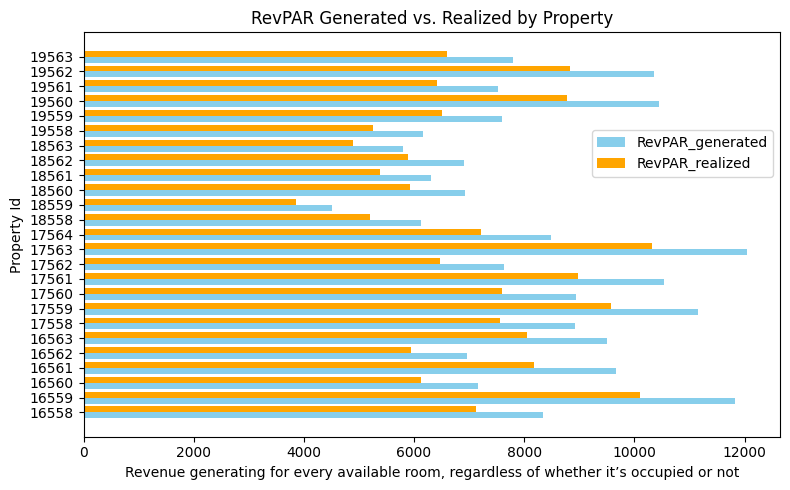

In [321]:
y = np.arange(len(prop_id['property_id']))  
bar_height = 0.40  
fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(y - bar_height/2,prop_id['RevPAR_generated'] , height=bar_height, label='RevPAR_generated', color='skyblue')
ax.barh(y + bar_height/2, prop_id['RevPAR_realized'], height=bar_height, label='RevPAR_realized', color='orange')

# Set y-ticks and labels
ax.set_yticks(y)
ax.set_yticklabels(prop_id['property_id'])

# Add labels, title, and legend
ax.set_xlabel('Revenue generating for every available room, regardless of whether it’s occupied or not')
ax.set_ylabel('Property Id')
ax.set_title('RevPAR Generated vs. Realized by Property')
ax.legend()
ax.legend(loc='center right', bbox_to_anchor=(1, 0.7))
plt.tight_layout()
plt.show()

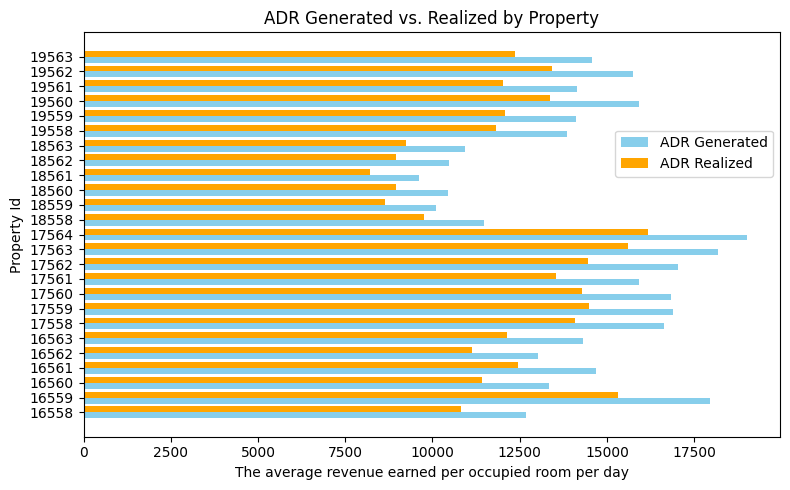

In [322]:
y = np.arange(len(prop_id['property_id']))  
bar_height = 0.40  
fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(y - bar_height/2,prop_id['ADR_generated'] , height=bar_height, label='ADR Generated', color='skyblue')
ax.barh(y + bar_height/2, prop_id['ADR_realized'], height=bar_height, label='ADR Realized', color='orange')

# Set y-ticks and labels
ax.set_yticks(y)
ax.set_yticklabels(prop_id['property_id'])

# Add labels, title, and legend
ax.set_xlabel('The average revenue earned per occupied room per day')
ax.set_ylabel('Property Id')
ax.set_title('ADR Generated vs. Realized by Property')
ax.legend()
ax.legend(loc='center right', bbox_to_anchor=(1, 0.7))
plt.tight_layout()
plt.show()

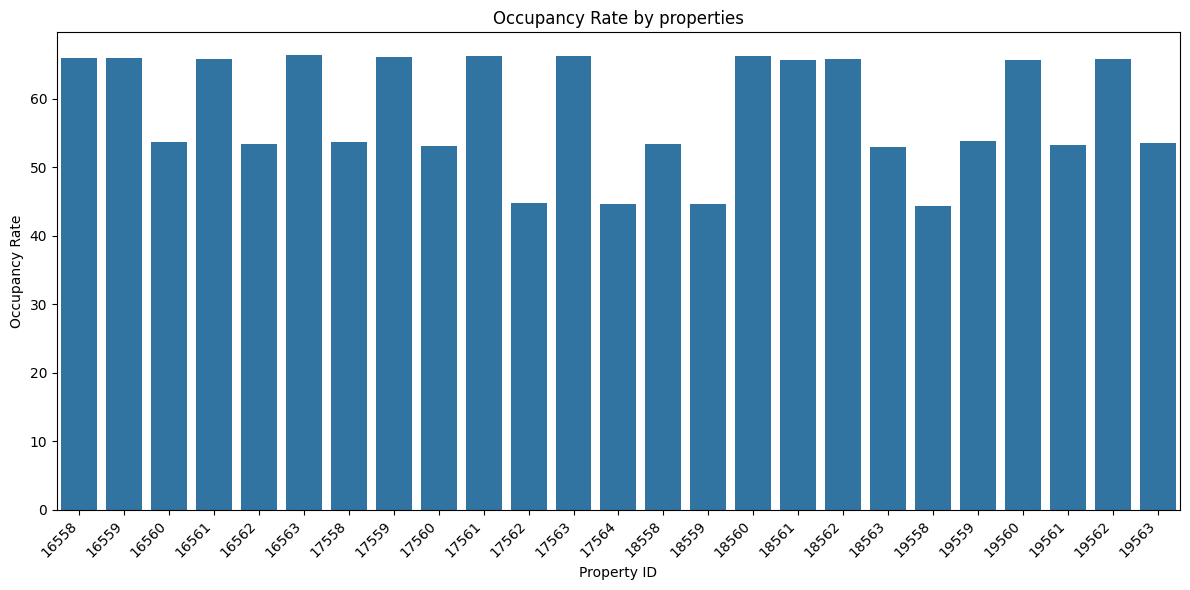

In [323]:
plt.figure(figsize=(12, 6))
sns.barplot(data=prop_id, x='property_id', y='Occupancy Rate')
plt.xticks(rotation=45, ha='right')
plt.title('Occupancy Rate by properties')
plt.xlabel('Property ID')
plt.ylabel('Occupancy Rate')
plt.tight_layout()
plt.show()

In [324]:
group_col = 'booking_platform'  
booking_partners = df.groupby(group_col)['booking_status'].value_counts().unstack().reset_index()
booking_partners['Conversion Rate']=(booking_partners['Checked Out']/(booking_partners['Checked Out']+booking_partners['No Show']+booking_partners['Cancelled']))*100
booking_partners

booking_status,booking_platform,Cancelled,Checked Out,No Show,Conversion Rate
0,direct offline,1575,4541,347,70.261488
1,direct online,3201,9040,612,70.333774
2,journey,1907,5468,360,70.691661
3,logtrip,3433,9995,721,70.641035
4,makeyourtrip,6417,18036,1289,70.064486
5,others,13116,36965,2656,70.093104
6,tripster,2285,6431,479,69.940185


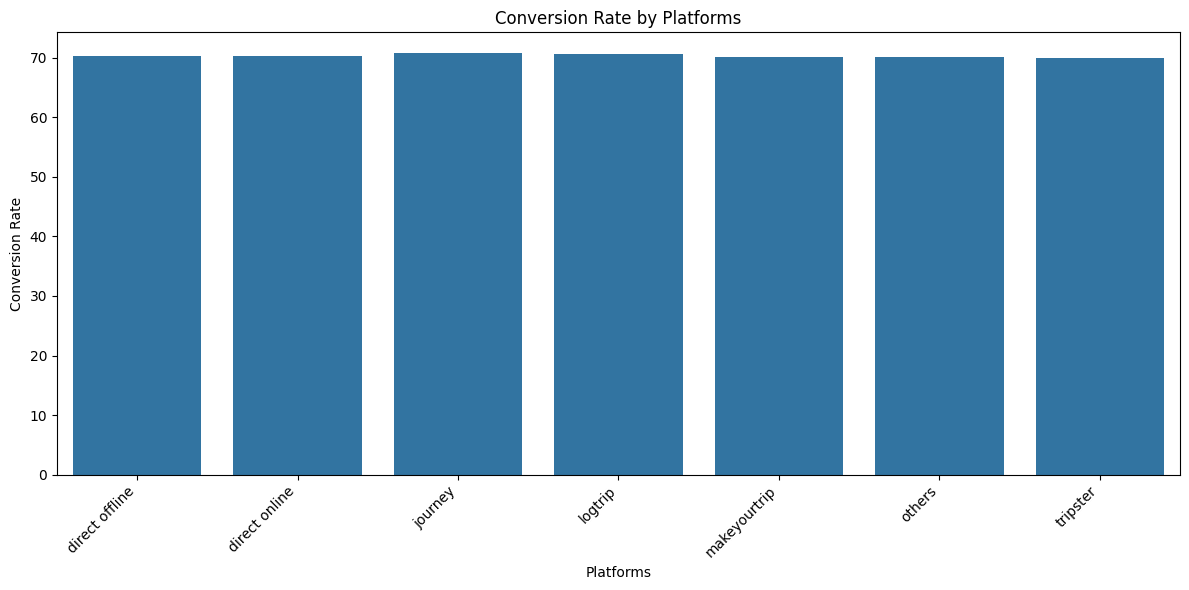

In [325]:
plt.figure(figsize=(12, 6))
sns.barplot(data=booking_partners, x='booking_platform', y='Conversion Rate')
plt.xticks(rotation=45, ha='right')
plt.title('Conversion Rate by Platforms')
plt.xlabel('Platforms')
plt.ylabel('Conversion Rate')
plt.tight_layout()
plt.show()

In [326]:
booking_partners['Conversion Rate']=(booking_partners['Checked Out']/(booking_partners['Checked Out']+booking_partners['No Show']+booking_partners['Cancelled']))*100
booking_partners2=df.groupby(group_col).agg({'revenue_generated':'sum','revenue_realized':'sum','no_guests':'sum'}).reset_index()
#booking_partners2['revenue_leaked']=booking_partners2['revenue_generated']-booking_partners2['revenue_realized']
booking_partners2['Avg Revenue per Booking']=booking_partners2['revenue_realized']/booking_partners['Checked Out']
booking_partners2['Avg Revenue per Guest']=booking_partners2['revenue_realized']/booking_partners2['no_guests']
booking_partners2

,booking_platform,revenue_generated,revenue_realized,no_guests,Avg Revenue per Booking,Avg Revenue per Guest
0,direct offline,97091425,82801660,13102,18234.234750,6319.772554
1,direct online,190817760,162425889,26178,17967.465597,6204.671442
2,journey,115292435,98036498,15727,17929.132772,6233.642653
3,logtrip,210456200,179888414,28638,17997.840320,6281.458691
4,makeyourtrip,384211545,326297685,52352,18091.466234,6232.764460
5,others,786756370,670153069,107084,18129.394535,6258.199815
6,tripster,138028580,117554645,18994,18279.372570,6189.041013


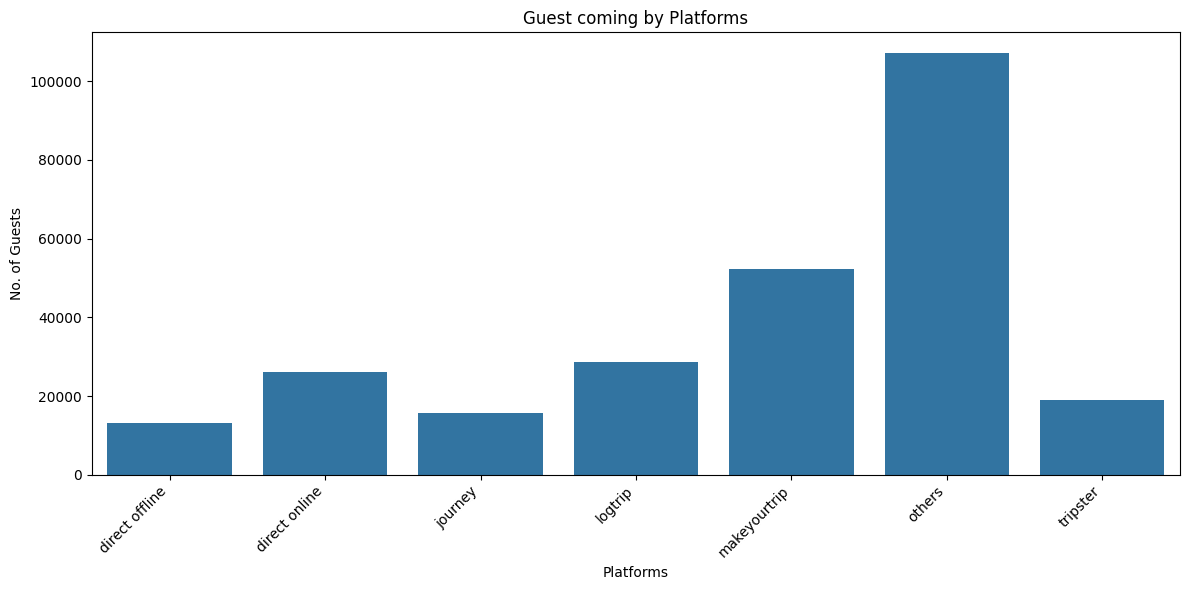

In [327]:
plt.figure(figsize=(12, 6))
sns.barplot(data=booking_partners2, x='booking_platform', y='no_guests')
plt.xticks(rotation=45, ha='right')
plt.title('Guest coming by Platforms')
plt.xlabel('Platforms')
plt.ylabel('No. of Guests')
plt.tight_layout()
plt.show()

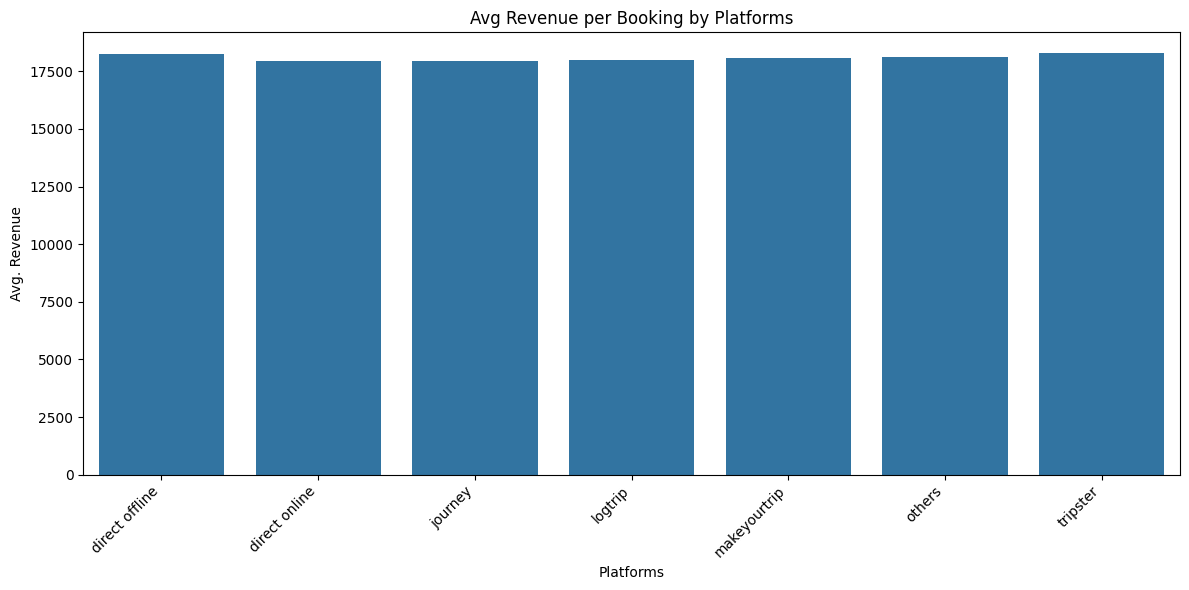

In [328]:
plt.figure(figsize=(12, 6))
sns.barplot(data=booking_partners2, x='booking_platform', y='Avg Revenue per Booking')
plt.xticks(rotation=45, ha='right')
plt.title('Avg Revenue per Booking by Platforms')
plt.xlabel('Platforms')
plt.ylabel('Avg. Revenue')
plt.tight_layout()
plt.show()

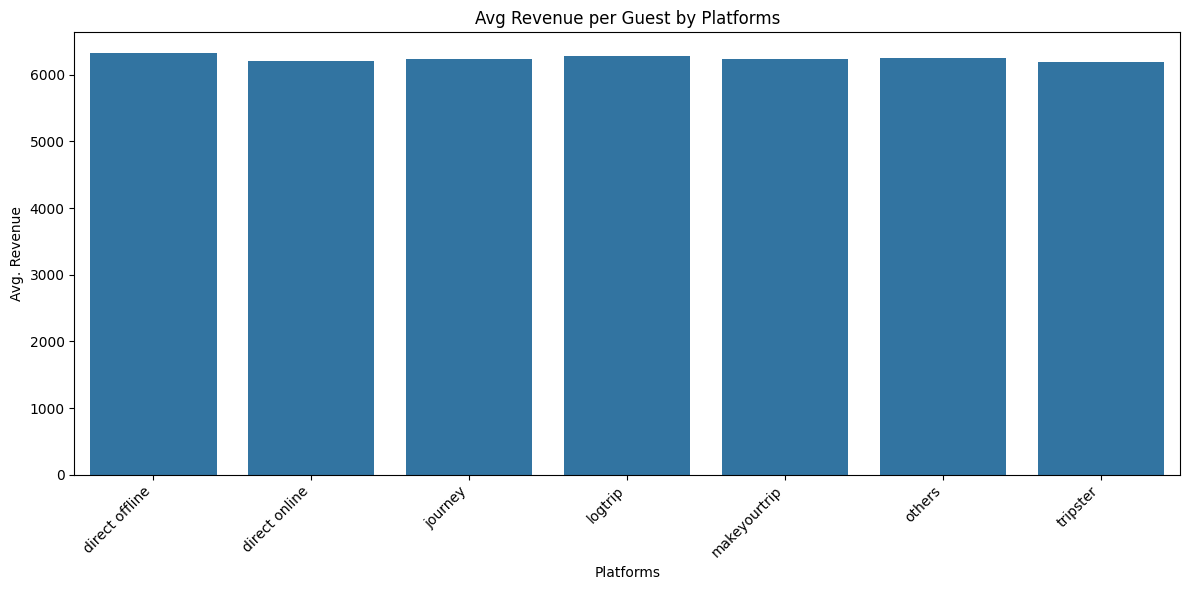

In [329]:
plt.figure(figsize=(12, 6))
sns.barplot(data=booking_partners2, x='booking_platform', y='Avg Revenue per Guest')
plt.xticks(rotation=45, ha='right')
plt.title('Avg Revenue per Guest by Platforms')
plt.xlabel('Platforms')
plt.ylabel('Avg. Revenue')
plt.tight_layout()
plt.show()

In [330]:
df['check_in_date'] = pd.to_datetime(df['check_in_date'])
df['checkout_date'] = pd.to_datetime(df['checkout_date'])
df['nights'] = (df['checkout_date'] - df['check_in_date']).dt.days
prop_id4=df.groupby('property_id')['nights'].sum().reset_index()
prop_id4= prop_id4.merge(prop_id, on='property_id', how='left')
prop_id4['Avg_night_stay']=prop_id4['nights']/prop_id4['successful_bookings']
prop_id4

,property_id,nights,successful_bookings,capacity,property_name,category,city,RevPAR_generated,RevPAR_realized,ADR_generated,ADR_realized,Occupancy Rate,Avg_night_stay
0,16558,8248,3153,4784,Atliq Grands,Luxury,Delhi,8348.992475,7124.969900,12667.802093,10810.610847,65.907191,2.615921
1,16559,19025,7338,11132,Atliq Exotica,Luxury,Mumbai,11828.102767,10095.183974,17943.641319,15314.743527,65.918074,2.592668
2,16560,8034,4693,8740,Atliq City,Business,Delhi,7160.295195,6132.073684,13334.962710,11420.056254,53.695652,1.711911
3,16561,11601,4418,6716,Atliq Blu,Luxury,Delhi,9669.693270,8183.083383,14699.334541,12439.472159,65.783204,2.625849
4,16562,12531,4820,9016,Atliq Bay,Luxury,Delhi,6963.385093,5946.529503,13025.286307,11123.217842,53.460515,2.599793
5,16563,12251,7147,10764,Atliq Palace,Business,Delhi,9503.124303,8049.758082,14312.526934,12123.631734,66.397250,1.714146
6,17558,13249,5036,9384,Atliq Grands,Luxury,Mumbai,8924.592391,7552.668478,16629.939436,14073.518864,53.665814,2.630858
7,17559,16058,6142,9292,Atliq Exotica,Luxury,Mumbai,11163.787667,9574.982889,16889.273038,14485.630251,66.099871,2.614458
8,17560,10318,6013,11316,Atliq City,Business,Mumbai,8949.344733,7588.713768,16841.973225,14281.371196,53.137151,1.715949
9,17561,13540,5183,7820,Atliq Blu,Luxury,Mumbai,10542.043478,8982.539130,15905.610650,13552.663708,66.278772,2.612387


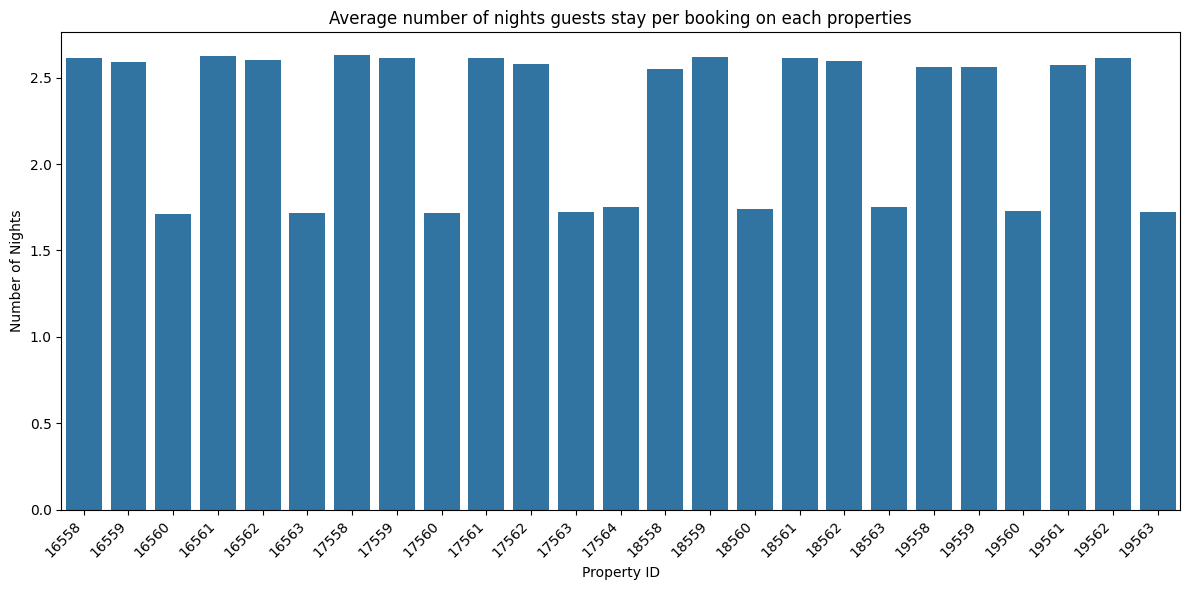

In [331]:
plt.figure(figsize=(12, 6))
sns.barplot(data=prop_id4, x='property_id', y='Avg_night_stay')
plt.xticks(rotation=45, ha='right')
plt.title('Average number of nights guests stay per booking on each properties')
plt.xlabel('Property ID')
plt.ylabel('Number of Nights')
plt.tight_layout()
plt.show()

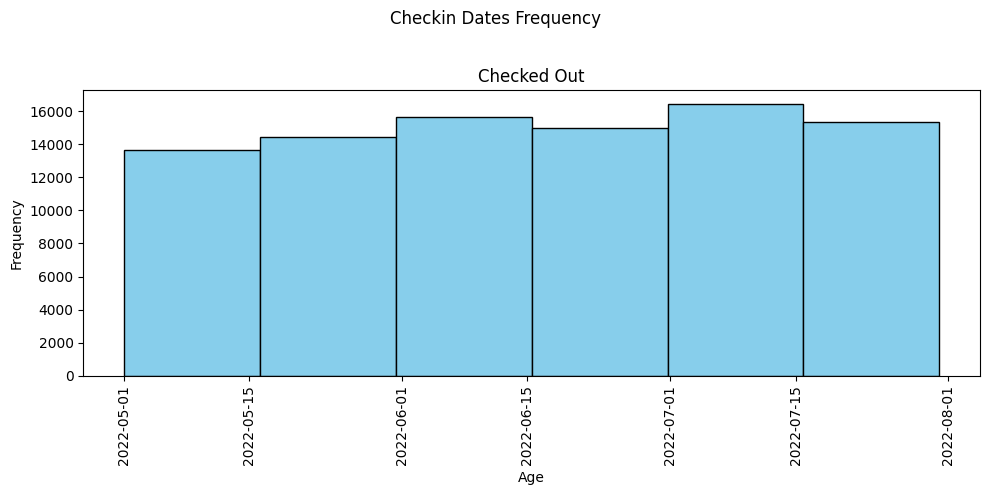

In [332]:
checkedout_df = df[df['booking_status'] == 'Checked Out'].reset_index()

checkedout_df.hist(column='check_in_date', by='booking_status', bins=6, color='skyblue', edgecolor='black', figsize=(10,5))
plt.suptitle('Checkin Dates Frequency')  
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()

In [333]:
bookings.to_csv('final_bookings_full_data.csv', index=False)


## Summary: Data Analysis Module – Key Findings

After a detailed cleaning and analysis of the hotel booking dataset, we observed several important insights:

- **Total Bookings:** Approximately 1.28 lakh bookings were recorded in the dataset.
- **Total Revenue Generated:** Around ₹19.2 crores was expected as revenue.
- **Total Revenue Realized:** Approximately ₹16.4 crores was actually earned.
- **Total Revenue Loss (Leakage):** ₹2.85 crores, which accounts for around **14.8% of total revenue**.
- **Average Revenue per Booking:** ₹14,916.
- **Cancellation Rate:** Roughly **32% of all bookings were cancelled**, contributing significantly to revenue loss.
- **Average Revenue Loss per Guest:** ₹1,116 per guest.

**Key Patterns Identified:**

- **Platform-wise Leakage:**  
Platforms like "Others" and "Makeyourtrip" contributed the highest absolute revenue losses.

- **Room Type-wise Leakage:**  
Premium and Presidential room categories showed higher revenue loss percentages.

- **Hotel Category-wise Leakage:**  
Luxury category hotels faced the most leakage in terms of both absolute value and percentage.

- **Time Trends:**  
Revenue leakage peaked during May 2022, suggesting seasonal or operational factors affecting that period.

- **Cancellation Analysis:**  
Some platforms and cities showed notably higher cancellation rates, directly impacting revenue realization.

- **Ratings Correlation:**  
There was no strong correlation between customer ratings and revenue loss, suggesting that most leakage was driven by cancellations and operational factors rather than customer dissatisfaction.

**Conclusion:**  
This Data Analysis Module provides a full overview of when, where, and how revenue leakage is occurring.  
It builds the foundation for our next step: **Root Cause Identification**, where we will investigate why these leakages are happening.